In [12]:
from statsforecast import StatsForecast
from statsforecast.models import (Naive, SeasonalNaive, AutoARIMA, AutoETS, AutoTheta, AutoCES)
from datasetsforecast.losses import mse, mae, smape
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore


from typing import List, Callable
from distributed import Client
from fugue import transform
from fugue_dask import DaskExecutionEngine

import warnings
warnings.filterwarnings("ignore")

In [47]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2015-01-01', interval='1mo')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df

[*********************100%%**********************]  8 of 8 completed


,unique_id,ds,y
0,AAPL,2015-01-01,26.149809
1,AAPL,2015-02-01,28.671934
2,AAPL,2015-03-01,27.882055
3,AAPL,2015-04-01,28.043400
4,AAPL,2015-05-01,29.192923
...,...,...,...
915,NVDA,2024-03-01,90.344337
916,NVDA,2024-04-01,86.394905
917,NVDA,2024-05-01,109.624001
918,NVDA,2024-06-01,123.529854


In [65]:
def detect_and_correct_anomalies(group):
    group = group.sort_values(by='ds', ascending=True).reset_index(drop=True)
    group['Z-Score'] = abs(zscore(group['y']))

    # Detectar y corregir anomalías
    group.loc[group['Z-Score'] > 3, 'y'] = np.nan
    group['y'] = group['y'].interpolate(method='linear')

    # Eliminar la columna Z-Score
    group = group.drop(columns=['Z-Score'])

    return group

ts_not_anom = Y_df.groupby('unique_id').apply(detect_and_correct_anomalies).reset_index(drop=True)
ts_not_anom_by_client = ts_not_anom.groupby('unique_id')


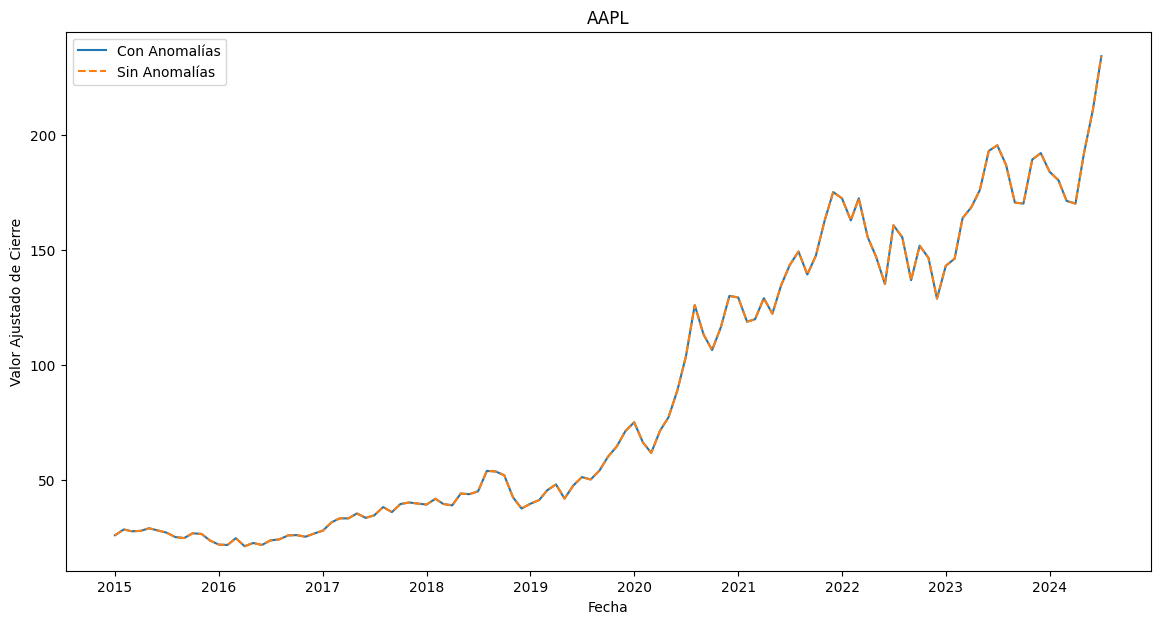

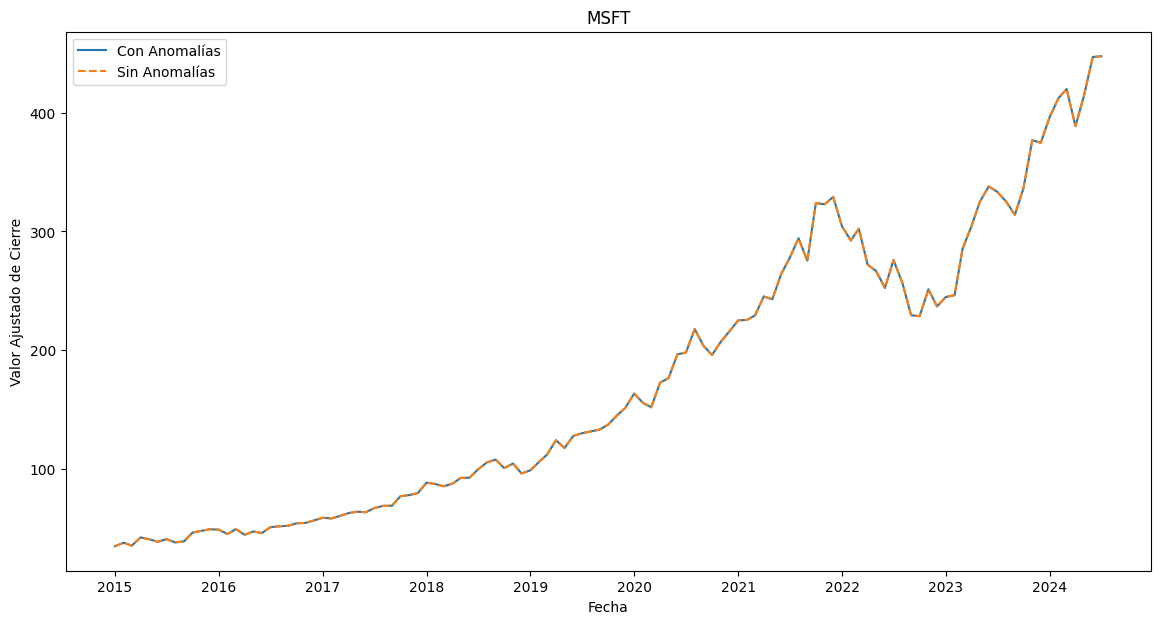

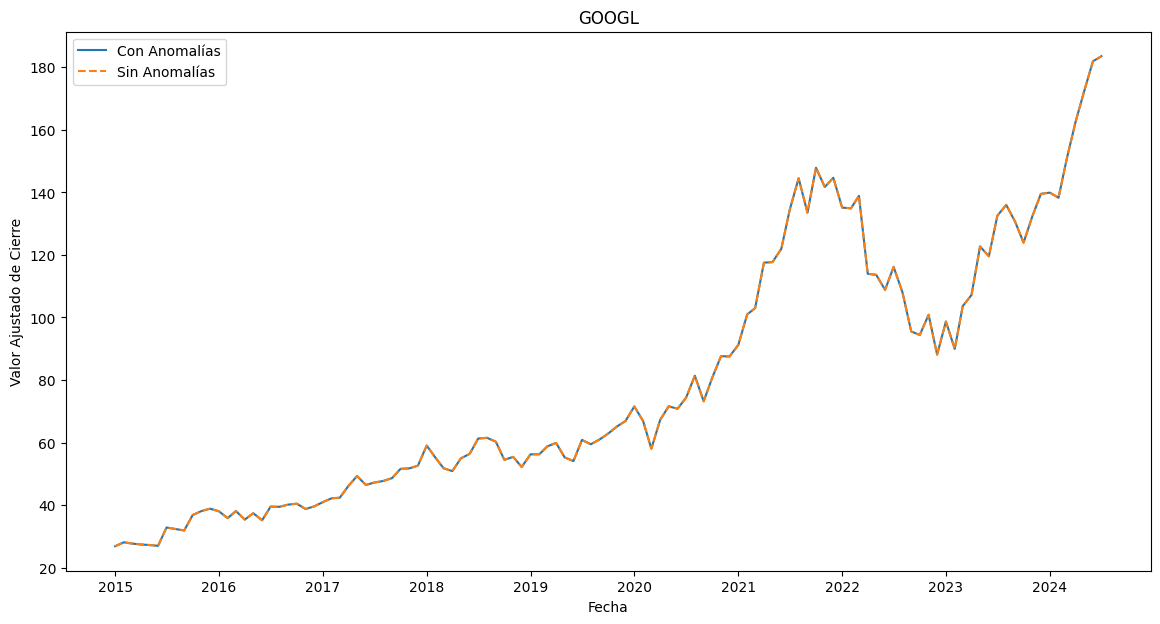

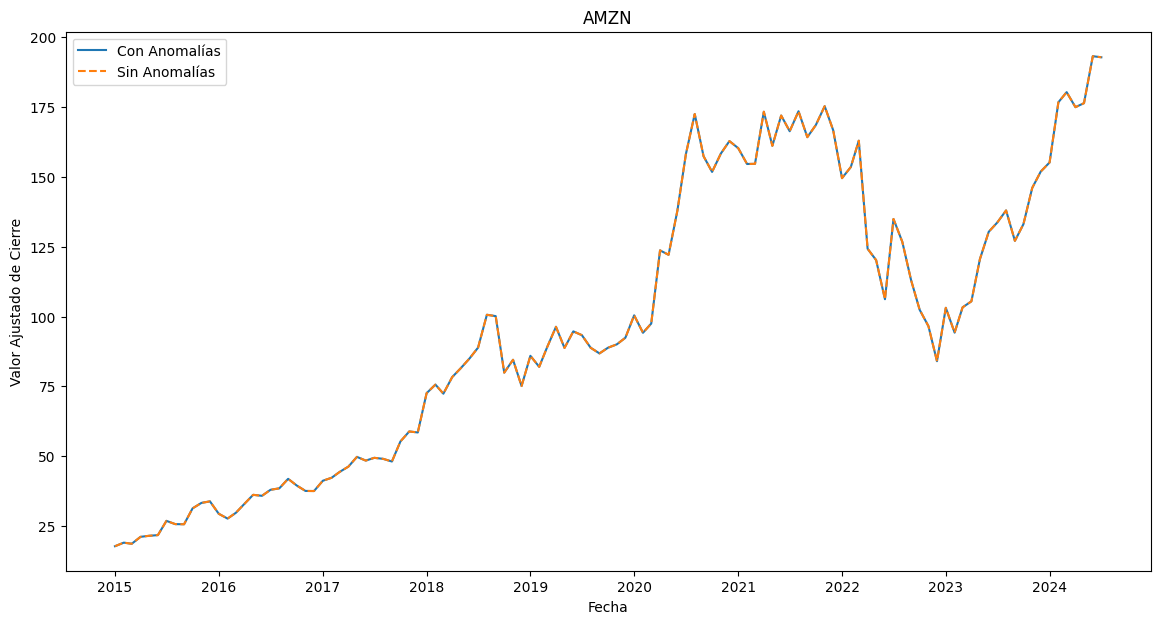

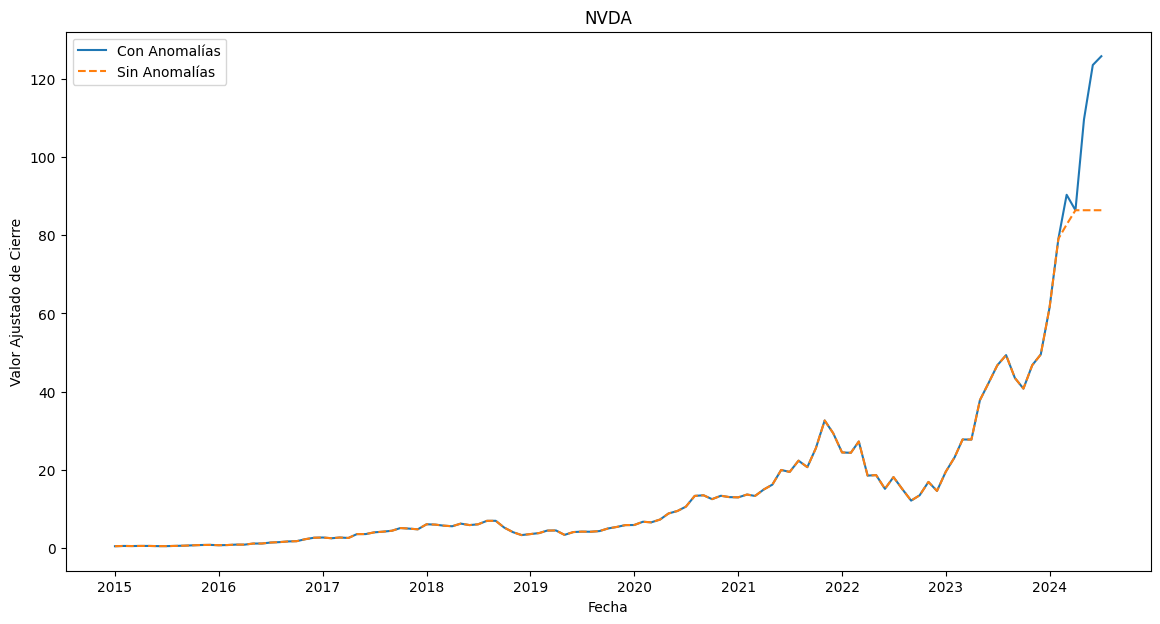

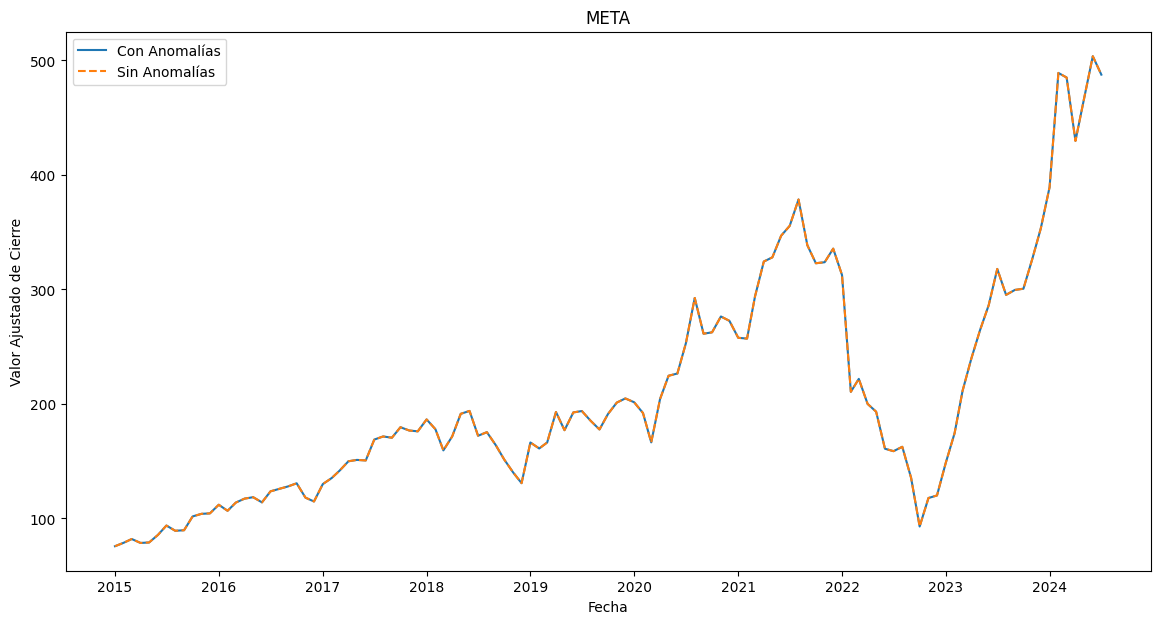

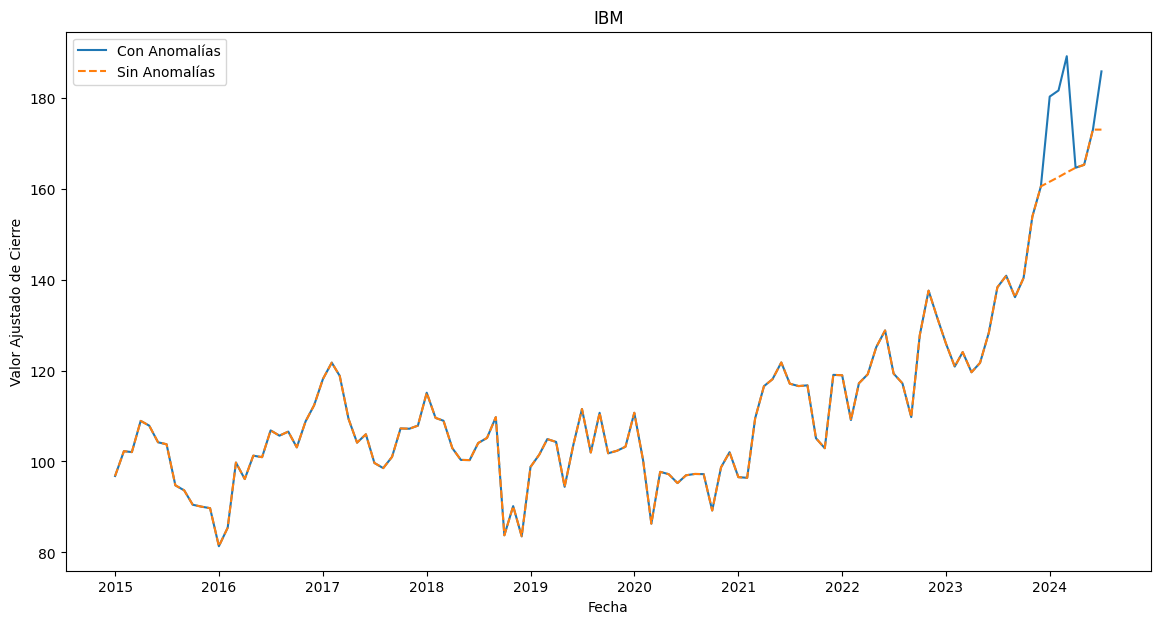

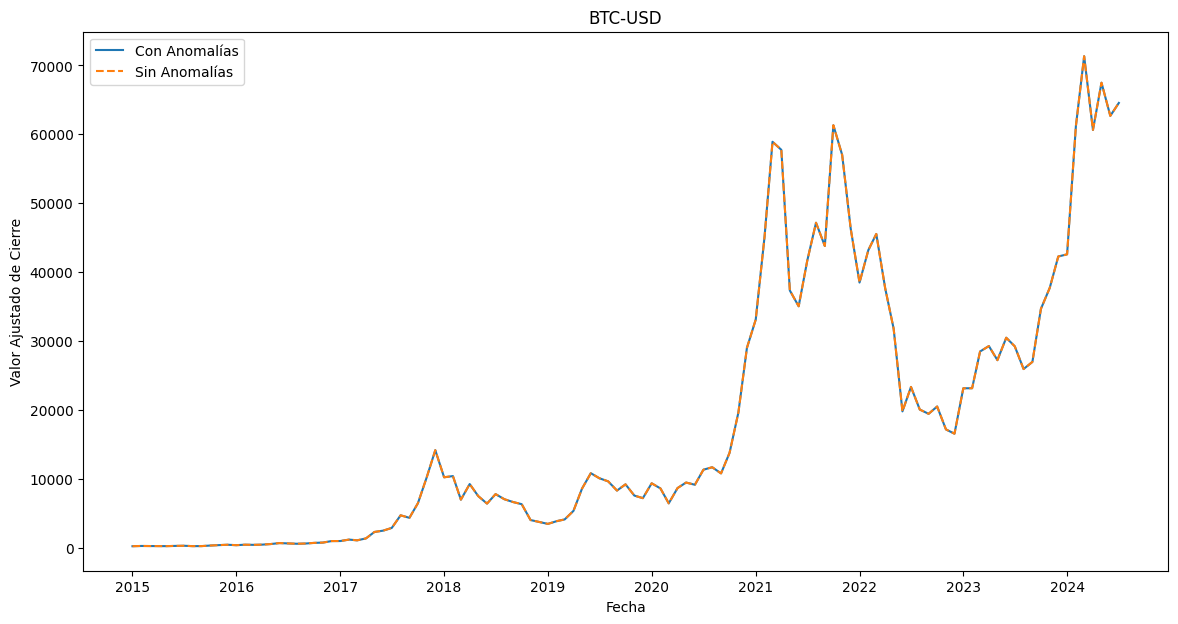

In [68]:
# Agrupar los datos originales y corregidos por 'unique_id' (ticker)
ts_original = Y_df.groupby('unique_id')
ts_corrected = ts_not_anom.groupby('unique_id')

# Iterar sobre cada ticker y graficar
for ticker in tickers:
    plt.figure(figsize=(14, 7))

    # Datos originales
    original_data = ts_original.get_group(ticker)
    corrected_data = ts_corrected.get_group(ticker)

    plt.plot(original_data['ds'], original_data['y'], label='Con Anomalías')
    plt.plot(corrected_data['ds'], corrected_data['y'], label='Sin Anomalías', linestyle='--')

    plt.title(f'{ticker}')
    plt.xlabel('Fecha')
    plt.ylabel('Valor Ajustado de Cierre')
    plt.legend()
    plt.show()


In [69]:
# Contar NaNs por unique_id
nan_counts = ts_not_anom.groupby('unique_id')['y'].apply(lambda x: x.isna().sum())
print(nan_counts)

unique_id
AAPL       0
AMZN       0
BTC-USD    0
GOOGL      0
IBM        0
META       0
MSFT       0
NVDA       0
Name: y, dtype: int64


In [70]:
season_length = 12 # Define season length as 12 months for monthly data
horizon = 1 # Forecast horizon is set to 1 month

# Define a list of models for forecasting
models = [
    Naive(),
    SeasonalNaive(season_length=season_length),
    AutoARIMA(season_length=season_length), # ARIMA model with automatic order selection and seasonal component
    AutoETS(season_length=season_length), # ETS model with automatic error, trend, and seasonal component
    AutoTheta(season_length=season_length), # Theta model with automatic seasonality detection
    AutoCES(season_length=season_length), # CES model with automatic seasonality detection
    
]

# Instantiate StatsForecast class with models, data frequency ('M' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='M',  # frequency of the data
    n_jobs=1  # number of jobs to run in parallel, -1 means using all processors
)

In [71]:
# Generate forecasts for the specified horizon using the sf object
Y_hat_df = sf.forecast(df=ts_not_anom, h=horizon) # forecast data
Y_hat_df.head() 

,ds,Naive,SeasonalNaive,AutoARIMA,AutoETS,AutoTheta,CES
unique_id,,,,,,,
AAPL,2024-07-31,234.059998,186.877533,236.874252,236.296158,242.025146,233.983459
AMZN,2024-07-31,192.876297,138.009995,192.876297,194.233688,194.243729,197.805054
BTC-USD,2024-07-31,64554.085938,25931.472656,64824.871094,64553.898438,65011.269531,63887.660156
GOOGL,2024-07-31,183.559998,136.013901,183.559998,184.100311,184.578110,188.560760
IBM,2024-07-31,172.949997,140.836899,172.949997,172.852661,173.262848,171.173645


In [72]:
cv_df = sf.cross_validation(df=Y_df, h=horizon, n_windows=5, step_size=horizon, level=[99])
cv_df.head()

,ds,cutoff,y,Naive,Naive-lo-99,Naive-hi-99,SeasonalNaive,SeasonalNaive-lo-99,SeasonalNaive-hi-99,AutoARIMA,...,AutoARIMA-hi-99,AutoETS,AutoETS-lo-99,AutoETS-hi-99,AutoTheta,AutoTheta-lo-99,AutoTheta-hi-99,CES,CES-lo-99,CES-hi-99
unique_id,,,,,,,,,,,,,,,,,,,,,
AAPL,2024-03-01,2024-02-01,171.247726,180.275131,159.370834,201.179428,163.802307,88.182266,239.422348,180.275131,...,201.179428,181.236435,142.467468,220.005402,185.876434,169.628052,202.455414,184.646057,154.718353,214.249023
AAPL,2024-04-01,2024-03-01,170.099289,171.247726,150.320892,192.174561,168.550491,93.288651,243.812332,171.247726,...,192.174561,172.173233,135.442917,208.903564,169.671234,153.557404,186.112946,174.510803,144.324905,201.732941
AAPL,2024-05-01,2024-04-01,191.989594,170.099289,149.265045,190.933533,176.070099,101.184448,250.955750,170.099289,...,190.933533,171.016541,134.702988,207.330078,170.566803,154.758865,186.696365,170.460938,141.466919,199.543854
AAPL,2024-06-01,2024-05-01,210.619995,191.989594,170.575180,213.404007,192.945328,118.319695,267.570953,191.989594,...,213.404007,192.991394,151.785324,234.197449,195.699387,179.179916,212.554932,191.231613,161.480377,220.252670
AAPL,2024-07-01,2024-06-01,234.059998,210.619995,188.827820,232.412170,195.412216,121.016602,269.807831,210.306442,...,231.908722,212.483688,167.048569,257.918823,223.774078,206.180984,241.725143,214.352448,185.330338,243.880188


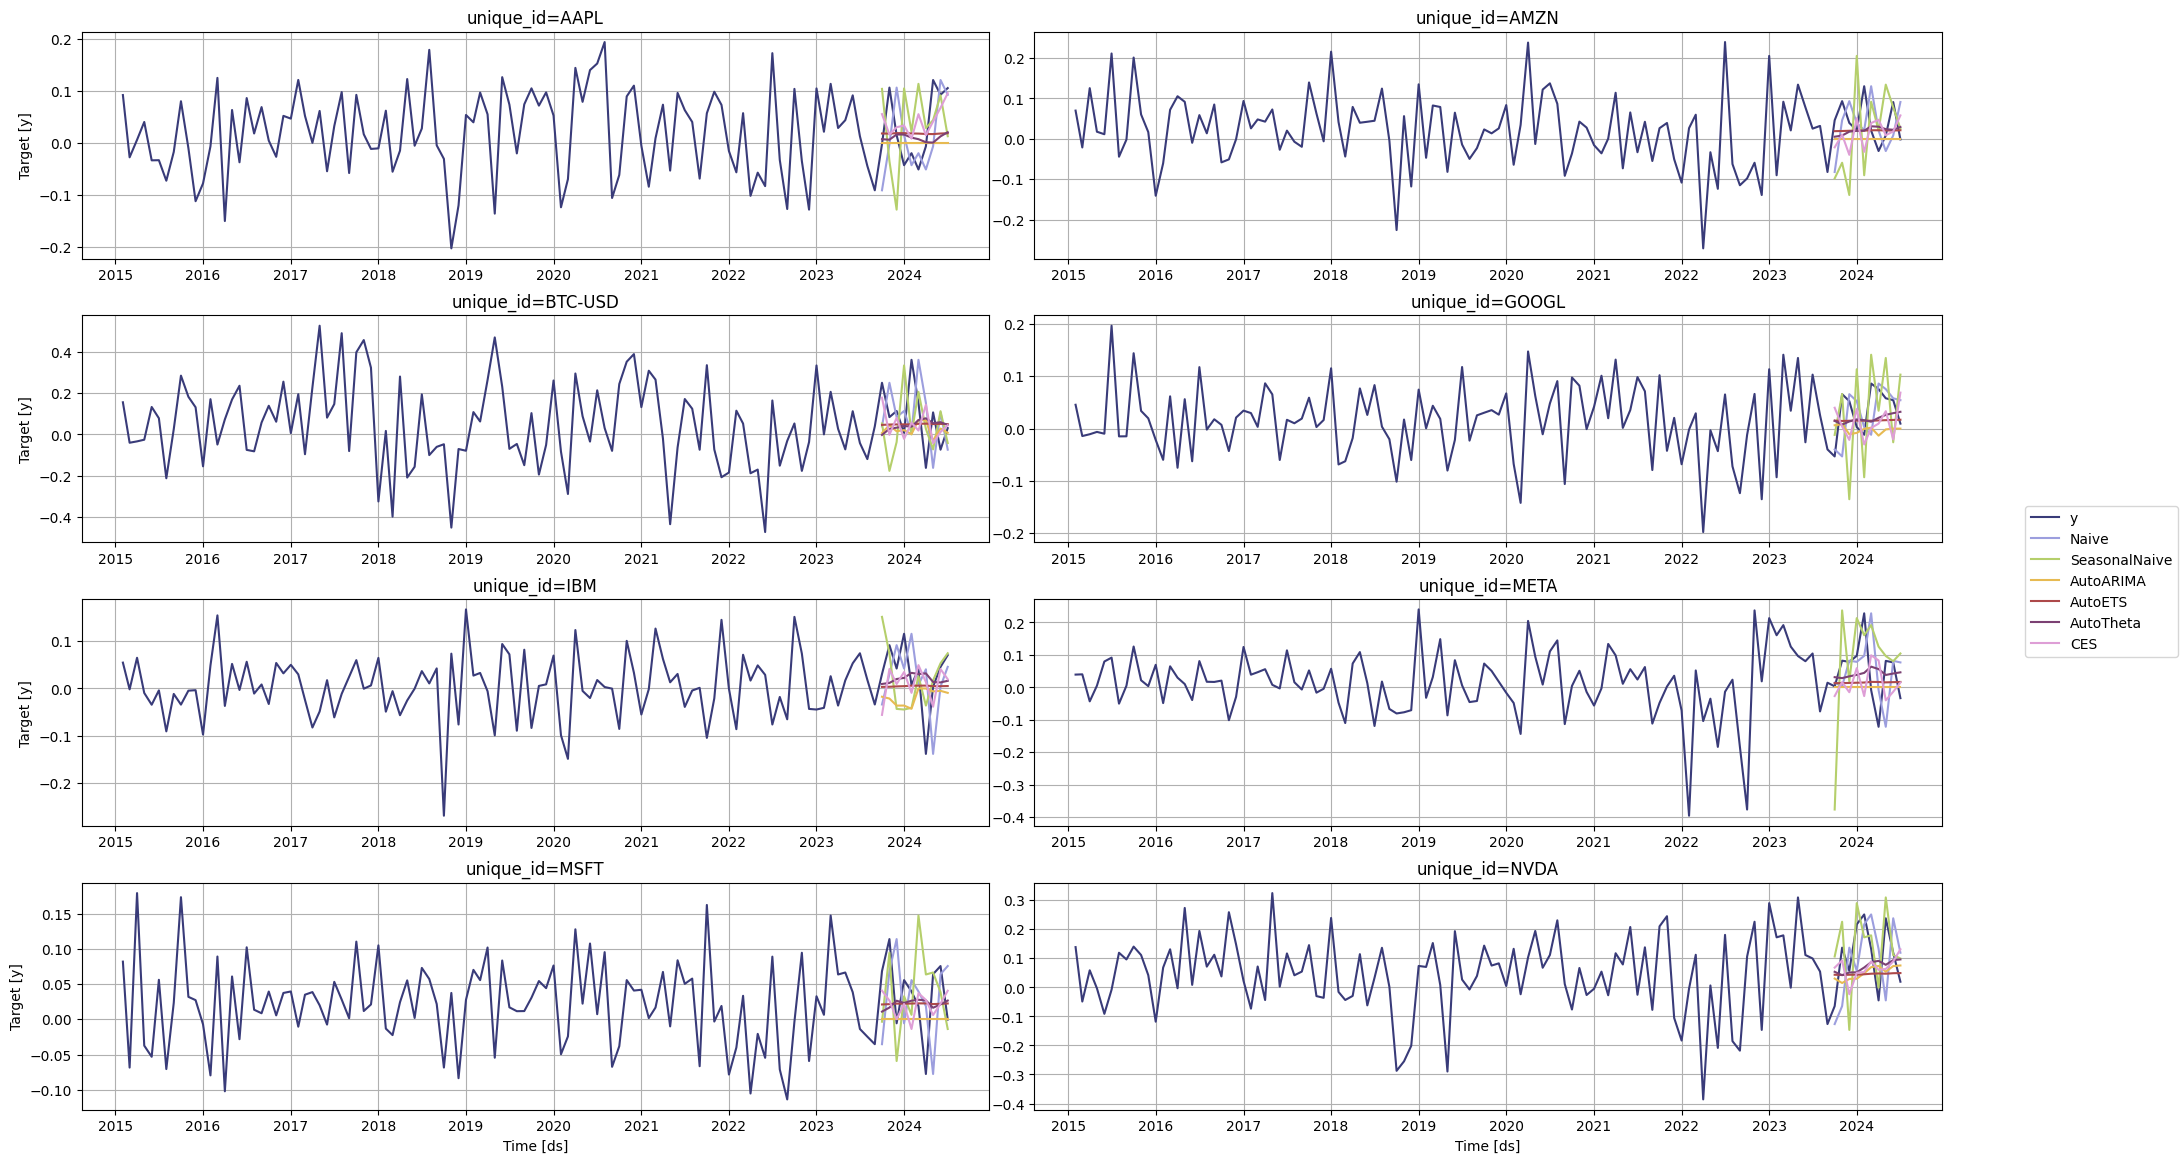

In [28]:
StatsForecast.plot(Y_df, cv_df.drop(['cutoff', 'y'], axis=1))

In [73]:
cv_df = pd.DataFrame(cv_df)
cv_df.index.name = 'unique_id'

# Transformar índice en columna
cv_df.reset_index(inplace=True)

In [74]:
def evaluate(df: pd.DataFrame, metrics: List[Callable]) -> pd.DataFrame:
    eval_ = {}
    models = df.loc[:, ~df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
    for model in models:
        eval_[model] = {}
        for metric in metrics:
            eval_[model][metric.__name__] = metric(df['y'], df[model])
    eval_df = pd.DataFrame(eval_).rename_axis('metric').reset_index()
    eval_df.insert(0, 'cutoff', df['cutoff'].iloc[0])
    eval_df.insert(0, 'unique_id', df['unique_id'].iloc[0])
    return eval_df

In [75]:
str_models = cv_df.loc[:, ~cv_df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
str_models = ','.join([f"{model}:float" for model in str_models])
cv_df['cutoff'] = cv_df['cutoff'].astype(str)
cv_df['unique_id'] = cv_df['unique_id'].astype(str)

In [76]:
client = Client() # without this, dask is not in distributed mode
# fugue.dask.dataframe.default.partitions determines the default partitions for a new DaskDataFrame
engine = DaskExecutionEngine({"fugue.dask.dataframe.default.partitions": 96})

In [77]:
evaluation_df = transform(
    cv_df.loc[:, ~cv_df.columns.str.contains('lo|hi')], 
    evaluate, 
    engine="dask",
    params={'metrics': [mse, mae, smape]}, 
    schema=f"unique_id:str,cutoff:str,metric:str, {str_models}", 
    as_local=True,
    partition={'by': ['unique_id', 'cutoff']}
)
evaluation_df.head()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask

2024-07-16 20:13:37,501 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9d94fded12d1947b7dcda7251d1f3381 initialized by task ('shuffle-transfer-9d94fded12d1947b7dcda7251d1f3381', 0) executed on worker tcp://127.0.0.1:49803
2024-07-16 20:13:41,051 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9d94fded12d1947b7dcda7251d1f3381 deactivated due to stimulus 'task-finished-1721153620.0840828'


,unique_id,cutoff,metric,Naive,SeasonalNaive,AutoARIMA,AutoETS,AutoTheta,CES
0,AAPL,2024-05-01,mse,347.091858,312.39386,347.091858,310.767578,222.624557,375.909363
1,AAPL,2024-05-01,mae,18.630402,17.674667,18.630402,17.628601,14.920609,19.388382
2,AAPL,2024-05-01,smape,9.254823,8.75926,9.254823,8.735434,7.344275,9.649523
3,BTC-USD,2024-04-01,mse,46984972.0,1621814528.0,106304640.0,46970300.0,39736376.0,89782880.0
4,BTC-USD,2024-04-01,mae,6854.558594,40271.757812,10310.414062,6853.488281,6303.679688,9475.382812


In [78]:
# Calculate the mean metric for each cross validation window
evaluation_df.groupby(['cutoff', 'metric']).mean(numeric_only=True)

Naive  SeasonalNaive    AutoARIMA       AutoETS  \
cutoff     metric                                                          
2024-02-01 mae     1273.874268    5440.322754   706.909668   1274.748047   
           mse      12840515.0    229584304.0   3884787.25    12845242.0   
           smape      6.389519      55.743237     4.924703      6.449366   
2024-03-01 mae     1353.789062    3984.057861  1524.865112   1354.519775   
           mse      14303276.0    123001384.0   18162668.0    14300622.0   
           smape      8.206515      47.107288     9.946575      8.520662   
2024-04-01 mae      871.730957     5099.98584  1304.641846    870.733398   
           mse       5873511.5    202734528.0   13288569.0     5871611.0   
           smape      8.510953      46.518406     9.029535      8.426785   
2024-05-01 mae      618.720825    4099.526367   894.887573    617.862488   
           mse      2896195.75    129622872.0    6196903.5    2895331.25   
           smape      7.869413      46.067741     6.989596      7.488563   
2024-06-01 mae       241.62384    4485.410156   401.993835    242.191879   
           mse     439947.4375    155980160.0  1236748.625  439733.53125   
           smape      3.362634      44.274845     4.415462      3.401719   

                      AutoTheta           CES  
cutoff     metric                              
2024-02-01 mae      1244.796143   1517.509888  
           mse       12256194.0    18254518.0  
           smape        6.47996      6.613953  
2024-03-01 mae      1396.408936     944.02417  
           mse       15205206.0     6809285.5  
           smape       8.586859      8.652961  
2024-04-01 mae       802.288208   1193.603271  
           mse        4967397.0    11222995.0  
           smape       8.233683      6.761328  
2024-05-01 mae       665.676453    179.140549  
           mse       3383904.25   214129.5625  
           smape       7.299922      6.589077  
2024-06-01 mae       177.373459    113.897018  
           mse     232021.96875  86976.210938  
           smape       2.825253      4.353535

<Axes: xlabel='error', ylabel='model'>

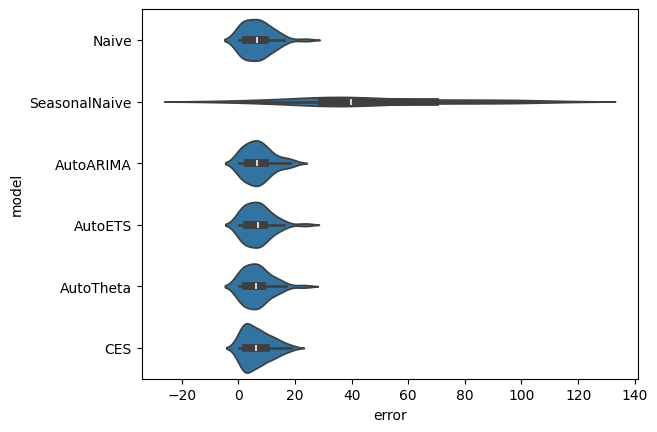

In [79]:
evaluation_df_melted = pd.melt(evaluation_df, id_vars=['unique_id', 'cutoff', 'metric'], var_name='model', value_name='error')
sns.violinplot(evaluation_df_melted.query('metric=="smape"'), x='error', y='model')

<Axes: xlabel='n', ylabel='best_model'>

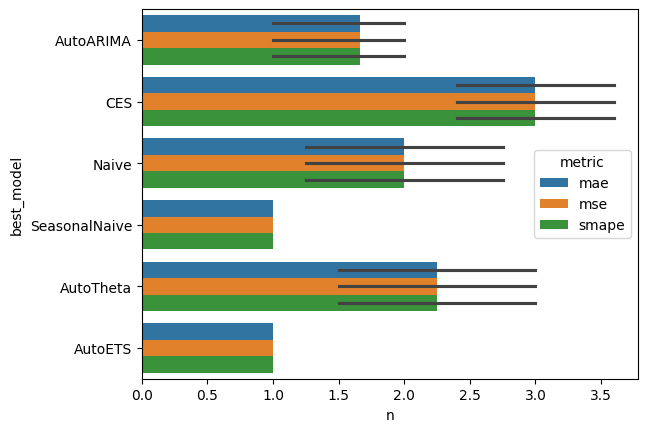

In [80]:
# Choose the best model for each time series, metric, and cross validation window
evaluation_df['best_model'] = evaluation_df.idxmin(axis=1, numeric_only=True)
# count how many times a model wins per metric and cross validation window
count_best_model = evaluation_df.groupby(['cutoff', 'metric', 'best_model']).size().rename('n').to_frame().reset_index()
# plot results
sns.barplot(count_best_model, x='n', y='best_model', hue='metric')